In [346]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [347]:
sensor_name = "Sensor 3"
test_folder = f"saved_model/{sensor_name}_model.h5"

test_dataset = f"dataset/cleaned/test_per_day/{sensor_name}_2024-11-14.csv"
actual_dataset = f"dataset/cleaned/test_per_day/{sensor_name}_2024-11-15.csv"

In [348]:
test_data = pd.read_csv(test_dataset)
test_data["created_at"] = pd.to_datetime(test_data["created_at"], format="ISO8601")

actual_data = pd.read_csv(actual_dataset)
actual_data["created_at"] = pd.to_datetime(actual_data["created_at"], format="ISO8601")

In [349]:
test_average_interval = test_data["created_at"].diff().dt.total_seconds().mean()
test_average_interval

np.float64(3.1015250026923216)

In [350]:
actual_average_interval = actual_data["created_at"].diff().dt.total_seconds().mean()
actual_average_interval

np.float64(3.6248495426701353)

In [351]:
test_data["time_seconds"] = (test_data["created_at"] - test_data["created_at"].min()).dt.total_seconds()
actual_data["time_seconds"] = (actual_data["created_at"] - actual_data["created_at"].min()).dt.total_seconds()

In [352]:
test_data = test_data[["power"]]

In [353]:
scaler = MinMaxScaler(feature_range=(0, 1))

test_data_scaled = scaler.fit_transform(test_data)

In [354]:
def create_sequences(data, time_steps=24):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
    return np.array(X)

In [355]:
X_test = create_sequences(test_data_scaled, time_steps=24)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = tf.keras.models.load_model(test_folder)

predicted_data = model.predict(X_test)

870/870 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


In [356]:
predicted_data_rescaled = scaler.inverse_transform(predicted_data.reshape(-1, 1))

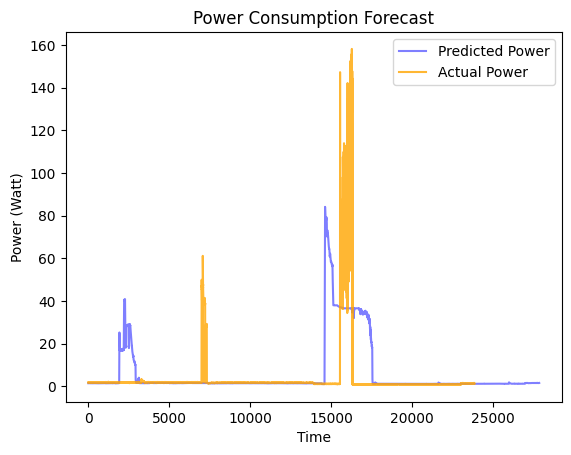

In [357]:
plt.plot(predicted_data_rescaled, label='Predicted Power', color='blue', alpha=0.5)
plt.plot(actual_data["power"], label='Actual Power', color='orange', alpha=0.8)
plt.legend()
plt.title("Power Consumption Forecast")
plt.xlabel("Time")
plt.ylabel("Power (Watt)")
plt.show()

In [358]:
total_energy_predicted = 0
interval = test_average_interval / 3600
for predicted_power in predicted_data_rescaled.flatten():
    predicted_energy_value = (predicted_power * interval) / 1000
    total_energy_predicted += predicted_energy_value

print("Total Energy Predicted:", total_energy_predicted.round(2), "kWh")

Total Energy Predicted: 0.15 kWh


In [359]:
total_energy_actual = 0
interval = actual_average_interval / 3600
for actual_power in actual_data["power"]:
    actual_energy_value = (actual_power * interval) / 1000
    total_energy_actual += actual_energy_value

print("Total Energy Actual:", total_energy_actual.round(2), "kWh")

Total Energy Actual: 0.11 kWh


In [360]:
difference = total_energy_predicted - total_energy_actual
percentage_difference = abs((difference / total_energy_actual) * 100)

print("Difference:", difference.round(2), "kWh")
print("Percentage Difference:", percentage_difference.round(2), "%")

Difference: 0.04 kWh
Percentage Difference: 36.74 %
